In [1]:
# !pip install tiktoken

In [3]:
import warnings
from pprint import pprint
warnings.filterwarnings('ignore')

In [4]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv('./credential/cred.env')

# Get the API key from the environment variables
api_key = os.environ.get("API_KEY")

# Check if the API key was found
if api_key:
  print("API Key loaded successfully.")
else:
  print("API Key not found in the environment variables.")
os.environ["OPENAI_API_KEY"] = api_key

API Key loaded successfully.


# Chapter 8. Patterns to Make the Most of LLMs

LLM ในปัจจุบันมีข้อจำกัดที่สำคัญ แต่ไม่ได้หมายความว่าแอปพลิเคชัน LLM ในฝันของคุณเป็นไปไม่ได้ที่จะสร้าง ประสบการณ์ที่คุณออกแบบสำหรับผู้ใช้ของแอปพลิเคชันของคุณจำเป็นต้องทำงานรอบๆ และในอุดมคติจะทำงานร่วมกับข้อจำกัดเหล่านั้น

**บทที่ 5 ได้กล่าวถึงการแลกเปลี่ยนที่สำคัญที่เราเผชิญเมื่อสร้างแอปพลิเคชัน LLM**:

- การแลกเปลี่ยนระหว่างตัวแทน (ความสามารถในการดำเนินการโดยอิสระ) และความน่าเชื่อถือ (ระดับที่เราสามารถไว้วางใจผลลัพธ์ของมัน) โดยสัญชาตญาณ แอปพลิเคชัน LLM ใดๆ ก็ตามจะมีประโยชน์กับเรามากกว่า หากดำเนินการเพิ่มเติมโดยไม่ต้องมีส่วนร่วมจากเรา แต่ถ้าเราปล่อยให้ตัวแทนไปไกลเกินไป แอปพลิเคชันจะหลีกเลี่ยงไม่ได้ที่จะทำสิ่งที่เราไม่ต้องการให้ทำ

รูปนี้ แสดงให้เห็นถึงการแลกเปลี่ยนนี้

---

<img align="top" src="../work/pics/Figure8-1.png"     style=" width:380px; padding: 10px; " >

---

เพื่อยืมแนวคิดจากสาขาอื่นๆ *(In finance, the efficient frontier in portfolio optimization; in economics, a production-possibility frontier; in engineering, the Pareto front.)* เราสามารถมองเห็นการแลกเปลี่ยนเป็นแนวเขตแดน - จุดทั้งหมดบนเส้นโค้งนี้คือสถาปัตยกรรม LLM ที่เหมาะสมที่สุดสำหรับแอปพลิเคชันบางอย่าง ทำเครื่องหมายตัวเลือกที่แตกต่างกันระหว่างตัวแทนและความน่าเชื่อถือ (ดูบทที่ 5 สำหรับภาพรวมของสถาปัตยกรรมแอปพลิเคชัน LLM ที่แตกต่างกัน) ตัวอย่างเช่น สังเกตว่าสถาปัตยกรรมเชนมีตัวแทนค่อนข้างต่ำ แต่มีความน่าเชื่อถือสูงกว่า ในขณะที่สถาปัตยกรรมตัวแทนมีตัวแทนสูงกว่าแต่มีความน่าเชื่อถือต่ำกว่า

มาสัมผัสกันโดยย่อเกี่ยวกับวัตถุประสงค์เพิ่มเติม (แต่ยังคงสำคัญ) อีกหลายประการที่คุณอาจต้องการให้แอปพลิเคชัน LLM ของคุณมี แอปพลิเคชัน LLM แต่ละตัวจะถูกออกแบบมาสำหรับการผสมผสานวัตถุประสงค์อย่างน้อยหนึ่งอย่างที่แตกต่างกัน:

- **เวลาแฝง (Latency)**
ลดเวลาในการรับคำตอบขั้นสุดท้ายให้น้อยที่สุด

- **ภูมิภาคปกครองตนเอง (Autonomy)**
ลดการหยุดชะงักสำหรับอินพุตของมนุษย์

- **ความแปรปรวน (Variance)**
ลดความแปรปรวนระหว่างการเรียกใช้งาน

นี่ไม่ได้มีจุดประสงค์เพื่อเป็นรายการที่ครอบคลุมของวัตถุประสงค์ที่เป็นไปได้ทั้งหมด แต่เป็นเพียงตัวอย่างของการแลกเปลี่ยนที่คุณเผชิญเมื่อสร้างแอปพลิเคชันของคุณ แต่ละวัตถุประสงค์จะทำให้วัตถุประสงค์อื่นๆ เป็นโมฆะหากได้รับน้ำหนักเต็มที่ (ตัวอย่างเช่น แอปพลิเคชันที่มีเวลาแฝงขั้นต่ำคือแอปพลิเคชันที่ไม่ได้ทำอะไรเลย) ดังรูปที่แสดงให้เห็นนี้

---

<img align="top" src="../work/pics/Figure8-2.png"     style=" width:380px; padding: 10px; " >

---

สิ่งที่เราต้องการจริงๆ ในฐานะนักพัฒนาแอปพลิเคชันคือการขยายขอบเขตของความสามารถ

"สำหรับระดับความน่าเชื่อถือที่เท่ากัน เราต้องการให้ระบบมีความสามารถในการทำงานที่หลากหลายมากขึ้น"
และ "สำหรับระดับความสามารถในการทำงานที่เท่ากัน เราต้องการให้ระบบมีความน่าเชื่อถือมากขึ้น"
**บทนี้กล่าวถึงเทคนิคต่างๆ ที่คุณสามารถใช้เพื่อให้บรรลุเป้าหมายนี้:**

- **เอาต์พุตแบบสตรีม/กลางทาง (Streaming/intermediate output):**
การรับรู้ถึงความคืบหน้าหรือได้รับผลลัพธ์บางส่วนระหว่างการประมวลผลจะช่วยให้ผู้ใช้รู้สึกสบายใจมากขึ้นแม้ว่าระบบจะใช้เวลานานในการตอบสนอง

- **เอาต์พุตที่มีโครงสร้าง (Structured output):**
การกำหนดรูปแบบเอาต์พุตที่ชัดเจน เช่น JSON หรือ XML จะช่วยให้ LLM ผลิตผลลัพธ์ที่สอดคล้องกับความคาดหวังของเราได้มากขึ้น

- **การมีส่วนร่วมของมนุษย์ (Human in the loop):**
การอนุญาตให้มนุษย์เข้ามามีส่วนร่วมในกระบวนการทำงานของระบบ เช่น การหยุดชั่วคราว การอนุมัติผลลัพธ์ การแก้ไข หรือการยกเลิกคำสั่ง จะช่วยเพิ่มความยืดหยุ่นและความน่าเชื่อถือของระบบ

- **โหมดข้อความทับซ้อน (Double texting modes):**
หากแอปพลิเคชัน LLM ใช้เวลานานในการตอบสนอง ผู้ใช้มักจะส่งคำสั่งใหม่เข้ามาโดยไม่รอคำตอบจากคำสั่งก่อนหน้า ดังนั้น ระบบควรออกแบบให้สามารถรับมือกับสถานการณ์นี้ได้

# Structured Output


บ่อยครั้งที่จำเป็นอย่างยิ่งที่จะต้องให้ LLM ส่งคืนเอาต์พุตที่มีโครงสร้าง อาจเป็นเพราะการใช้งานเอาต์พุตนั้นต่อไปต้องการข้อมูลในรูปแบบเฉพาะ (เช่น การกำหนดชื่อและชนิดข้อมูลของฟิลด์ต่างๆ ในเอาต์พุต) หรือเพื่อลดความแปรปรวนของผลลัพธ์ที่อาจเกิดขึ้นหากปล่อยให้ LLM สร้างเอาต์พุตในรูปแบบข้อความอิสระ

มีกลยุทธ์ที่แตกต่างกันหลายอย่างที่คุณสามารถใช้ได้กับ LLM ที่แตกต่างกัน:

- **การเขียนพรอมต์:**
วิธีนี้เกี่ยวข้องกับการขอให้ LLM (อย่างสุภาพ) ส่งคืนเอาต์พุตในรูปแบบที่ต้องการ (เช่น JSON, XML หรือ CSV)
ข้อดีของการเขียนพรอมต์คือสามารถใช้ได้กับ LLM เกือบทุกตัว
ข้อเสียคือ การเขียนพรอมต์เพียงอย่างเดียวอาจไม่เพียงพอที่จะรับประกันว่า LLM จะส่งคืนเอาต์พุตในรูปแบบที่ต้องการเสมอไป

- **การเรียกใช้งานเครื่องมือ:**
วิธีนี้ใช้ได้กับ LLM ที่ได้รับการปรับแต่งให้เลือกจากรายการรูปแบบเอาต์พุตที่เป็นไปได้ และสร้างผลลัพธ์ที่สอดคล้องกับรูปแบบที่เลือก
โดยทั่วไปจะเกี่ยวข้องกับการเขียน ชื่อ เพื่อระบุรูปแบบเอาต์พุต คำอธิบาย เพื่อช่วยให้ LLM ตัดสินใจว่าควรเลือกใช้รูปแบบใด และรูปแบบของเอาต์พุตที่ต้องการ (โดยทั่วไปจะอยู่ในรูปแบบ JSONSchema) สำหรับแต่ละรูปแบบเอาต์พุตที่เป็นไปได้

- **โหมด JSON:**
นี่คือโหมดที่มีอยู่ใน LLM บางตัว (เช่น โมเดล OpenAI รุ่นล่าสุด) ที่บังคับให้เอาต์พุตเป็นเอกสาร JSON ที่ถูกต้อง



โมเดลต่างๆอาจรองรับรูปแบบที่แตกต่างกันเหล่านี้ด้วยพารามิเตอร์ที่แตกต่างกันเล็กน้อย เพื่อให้ง่ายต่อการรับเอาต์พุตที่มีโครงสร้างจาก LLM โมเดล LangChain ได้ใช้ส่วนต่อประสานทั่วไป ซึ่งเป็นเมธอดที่เรียกว่า .`with_structured_output` โดยการเรียกใช้เมธอดนี้ และส่งผ่าน JSON schema หรือโมเดล Pydantic (ใน Python) หรือ Zod (ใน JS) โมเดลจะเพิ่มพารามิเตอร์ของโมเดลและตัวแยกวิเคราะห์เอาต์พุตที่จำเป็นเพื่อสร้างและส่งคืนเอาต์พุตที่มีโครงสร้าง เมื่อโมเดลใดโมเดลหนึ่งใช้กลยุทธ์ข้างต้นมากกว่าหนึ่งวิธี คุณสามารถกำหนดค่าว่าจะใช้วิธีใด

มาสร้างรูปแบบที่จะใช้กัน:

In [5]:
from pydantic import BaseModel, Field


class Joke(BaseModel):
    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")

**สังเกตว่าเราใส่ใจในการเพิ่มคำอธิบายสำหรับแต่ละฟิลด์**

นี่เป็นสิ่งสำคัญ เพราะร่วมกับชื่อของฟิลด์ ข้อมูลนี้จะเป็นสิ่งที่ LLM ใช้ในการตัดสินใจว่าส่วนใดของเอาต์พุตควรอยู่ในแต่ละฟิลด์
เราสามารถกำหนดรูปแบบด้วยสัญกรณ์ JSONSchema ดิบได้ ซึ่งจะมีลักษณะดังนี้:
```
{'properties': {'setup': {'description': 'The setup of the joke',
   'title': 'Setup',
   'type': 'string'},
  'punchline': {'description': 'The punchline to the joke',
   'title': 'Punchline',
   'type': 'string'}},
 'required': ['setup', 'punchline'],
 'title': 'Joke',
 'type': 'object'}
```

และตอนนี้มาดูการสร้างเอาต์พุตที่สอดคล้องกับ schema นี้โดย LLM

| Feature        | Structured Outputs | JSON mode | Adheres to schema | Compatible models                                    | Enabling                                        |
|----------------|--------------------|-----------|--------------------|----------------------------------------------------|-------------------------------------------------|
| JSON mode      | Yes               | Yes        | Yes (see supported schemas) | • gpt-4o-mini<br>• gpt-4o-2024-08-06 and later<br>• gpt-3.5-turbo<br>• gpt-4-*<br>• gpt-4o-* | `response_format: { type: "json_schema", json_schema: {"strict": true, "schema": ...} }` |
| Structured Output | Yes               | Yes        | Yes (see supported schemas) | • gpt-4o-mini<br>• gpt-4o-2024-08-06 and later<br>• gpt-3.5-turbo<br>• gpt-4-*<br>• gpt-4o-* | `response_format: { type: "json_object" }` |


In [6]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
model = model.with_structured_output(Joke)

result = model.invoke("Tell me a joke about cats")
print(result)
print(result.setup)
print(result.punchline)

setup='Why was the cat sitting on the computer?' punchline='Because it wanted to keep an eye on the mouse!'
Why was the cat sitting on the computer?
Because it wanted to keep an eye on the mouse!


| Feature | ChatOpenAI | OpenAI |
|---|---|---|
| **Purpose** | Designed for conversational models (e.g., gpt-3.5-turbo, gpt-4) | Designed for older models (e.g., text-davinci-003) |
| **API Endpoint** | chat/completions | completions |
| **Input** | List of messages (conversation history) | Single string |
| **Output** | Single message | Single string |
| **Key Use Cases** | Conversations, chatbots, maintaining context | Simple input/output interactions |

In [7]:
from pydantic import BaseModel
from openai import OpenAI

# Initialize OpenAI client
client = OpenAI()

# Define your data structure
class Joke(BaseModel):
    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")

# Generate a response and parse it into your structure
completion = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a helpful and harmless AI assistant."},
        {"role": "user", "content": "Tell me a joke about cats"}
    ],
    response_format=Joke,  # Pass your Pydantic model
)

# Extract the parsed joke
joke = completion.choices[0].message.parsed

# Print the joke
print(joke)
print(joke.setup)
print(joke.punchline)

setup='Why was the cat sitting on the computer?' punchline='Because it wanted to keep an eye on the mouse!'
Why was the cat sitting on the computer?
Because it wanted to keep an eye on the mouse!


```python
class Joke(BaseModel):
    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
model = model.with_structured_output(Joke)
result = model.invoke("Tell me a joke about cats")
```
**มีสองสามสิ่งที่ควรสังเกต:**

- เราสร้างอินสแตนซ์ของโมเดลตามปกติ โดยระบุชื่อโมเดลที่จะใช้และพารามิเตอร์อื่นๆ
- (Low Temperature)อุณหภูมิต่ำมักจะเหมาะกับการสร้างเอาต์พุตที่มีโครงสร้าง เนื่องจากจะช่วยลดโอกาสที่ LLM จะสร้างเอาต์พุตที่ไม่ถูกต้องซึ่งไม่เป็นไปตาม Schema
- หลังจากนั้น เราจะแนบ Schema เข้ากับโมเดล ซึ่งจะส่งคืนอ็อบเจ็กต์ใหม่ ซึ่งจะสร้างเอาต์พุตที่ตรงกับ Schema ที่ให้ไว้ เมื่อคุณส่งอ็อบเจ็กต์ Pydantic หรือ Zod สำหรับ Schema สิ่งนี้จะถูกใช้สำหรับการตรวจสอบความถูกต้องด้วย นั่นคือ หาก LLM สร้างเอาต์พุตที่ไม่เป็นไปตามนั้น ข้อผิดพลาดในการตรวจสอบความถูกต้องจะถูกส่งคืนให้คุณแทนที่จะเป็นเอาต์พุตที่ล้มเหลว
- สุดท้าย เราเรียกใช้โมเดลด้วยอินพุต (แบบอิสระ) ของเรา และรับเอาต์พุตที่ตรงกับโครงสร้างที่เราต้องการ

รูปแบบของการใช้อินพุตที่มีโครงสร้างนี้มีประโยชน์มากทั้งในฐานะเครื่องมือแบบสแตนด์อโลน ดังที่คุณเห็นด้านบน และเป็นส่วนหนึ่งของแอปพลิเคชันขนาดใหญ่ ตัวอย่างเช่น กลับไปดูบทที่ 5 ซึ่งเราใช้ความสามารถนี้เพื่อใช้ขั้นตอนการกำหนดเส้นทางของสถาปัตยกรรมเราเตอร์

# Intermediate Output
**เอาต์พุตระดับกลาง**

ยิ่งสถาปัตยกรรม LLM ของคุณซับซ้อนมากขึ้นเท่าไหร่ ก็มีแนวโน้มที่จะใช้เวลาในการประมวลผลนานขึ้นเท่านั้น หากคุณลองนึกถึงไดอะแกรมสถาปัตยกรรมในบทที่ 5 และ 6 ทุกครั้งที่คุณเห็นหลายขั้นตอน (หรือโหนด) ที่เชื่อมต่อกันเป็นลำดับหรือเป็นวง นั่นเป็นตัวบ่งชี้ว่าเวลาที่ใช้สำหรับการเรียกใช้งานทั้งหมดกำลังเพิ่มขึ้น

ความหน่วงที่เพิ่มขึ้นนี้ หากไม่ได้รับการแก้ไข อาจเป็นอุปสรรคต่อการนำแอปพลิเคชัน LLM ไปใช้โดยผู้ใช้ เนื่องจากผู้ใช้ส่วนใหญ่คาดหวังว่าแอปพลิเคชันคอมพิวเตอร์จะสร้างเอาต์พุตภายในไม่กี่วินาที มีกลยุทธ์หลายประการที่จะทำให้ความหน่วงที่สูงขึ้นนั้นยอมรับได้มากขึ้น **แต่ทั้งหมดอยู่ภายใต้แนวคิดของเอาต์พุตแบบสตรีมมิ่ง**
- นั่นคือการรับเอาต์พุตจากแอปพลิเคชันในขณะที่แอปพลิเคชันยังคงทำงานอยู่

สำหรับส่วนนี้ เราจะใช้สถาปัตยกรรมสุดท้ายที่อธิบายไว้ในหัวข้อ
**“การจัดการกับเครื่องมือจำนวนมาก”** ในบทที่ 6 โปรดกลับไปดูบทนั้นสำหรับโค้ดแบบเต็ม



ในการสร้างเอาต์พุตระดับกลางด้วย LangGraph สิ่งที่คุณต้องทำคือเรียกกราฟด้วยเมธอด `stream` ซึ่งจะให้ผลลัพธ์ของแต่ละโหนดทันทีที่แต่ละโหนดเสร็จสิ้น ลองมาดูว่ามันมีลักษณะอย่างไร:

In [8]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]

embeddings = OpenAIEmbeddings()
model = ChatOpenAI(temperature=0.1)

tools_retriever = InMemoryVectorStore.from_documents(
    [Document(tool.description, metadata={"name": tool.name}) for tool in tools],
    embeddings,
).as_retriever()

class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]

def model_node(state: State) -> State:
    selected_tools = [
        tool for tool in tools if tool.name in state["selected_tools"]
    ]
    res = model.bind_tools(selected_tools).invoke(state["messages"])
    return {"messages": res}

def select_tools(state: State) -> State:
    query = state["messages"][-1].content
    tool_docs = tools_retriever.invoke(query)
    return {"selected_tools": [doc.metadata["name"] for doc in tool_docs]}

builder = StateGraph(State)
builder.add_node("select_tools", select_tools)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "select_tools")
builder.add_edge("select_tools", "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

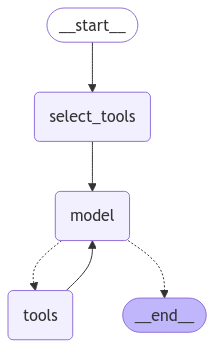

In [9]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

In [10]:
from langchain.schema import HumanMessage

input = {
  "messages": [
    HumanMessage("How old was the 30th president of the United States when he died?")
  ]
}
for c in graph.stream(input, stream_mode='updates'):
    print(c)

{'select_tools': {'selected_tools': ['duckduckgo_search', 'calculator']}}
{'model': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZZiivf4yyBJZlvjpXLNBZgup', 'function': {'arguments': '{"query":"30th president of the United States age at death"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 118, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-91ad6941-5dab-4ba6-8bd0-542cb1527498-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': '30th president of the United States age at death'}, 'id': 'call_ZZiivf4yyBJZlvjpXLNBZgup', 'type': 'tool_call'}], 

สังเกตว่ารายการเอาต์พุตแต่ละรายการเป็นพจนานุกรม โดยมีชื่อของโหนดที่ส่งออกมาเป็นคีย์ และเอาต์พุตของโหนดนั้นเป็นค่า สิ่งนี้ให้ข้อมูลสำคัญสองส่วนแก่คุณ:

- แอปพลิเคชันอยู่ที่ใดในปัจจุบัน นั่นคือ หากคุณนึกถึงไดอะแกรมสถาปัตยกรรมที่แสดงในบทก่อนๆ เราอยู่ในส่วนใดของไดอะแกรมนั้นในปัจจุบัน
- การอัปเดตแต่ละครั้งไปยังสถานะที่ใช้ร่วมกันของแอปพลิเคชัน ซึ่งรวมกันเป็นเอาต์พุตสุดท้ายของกราฟ

นอกจากนี้ LangGraph ยังรองรับโหมดสตรีมเพิ่มเติม:

- `updates` (การอัปเดต) นี่คือโหมดเริ่มต้น อธิบายไว้ข้างต้น
- `values` (ค่า) โหมดนี้จะให้สถานะปัจจุบันของกราฟทุกครั้งที่สถานะเปลี่ยนแปลง นั่นคือหลังจากที่โหนดแต่ละชุดประมวลผลเสร็จสิ้น โหมดนี้มีประโยชน์เมื่อวิธีการแสดงเอาต์พุตของคุณต่อผู้ใช้ติดตามรูปร่างของสถานะกราฟอย่างใกล้ชิด
- `debug` (การแก้ไขข้อบกพร่อง) โหมดนี้จะให้เหตุการณ์โดยละเอียดทุกครั้งที่มีบางอย่างเกิดขึ้นในกราฟของคุณ รวมถึง:

  - เหตุการณ์ `checkpoint` (จุดตรวจสอบ) ทุกครั้งที่มีการบันทึกจุดตรวจสอบใหม่ของสถานะปัจจุบันลงในฐานข้อมูล
  - เหตุการณ์ `task` (งาน) ที่ส่งออกมาเมื่อโหนดกำลังจะเริ่มทำงาน
  - เหตุการณ์ `task_result` (ผลลัพธ์ของงาน) ที่ส่งออกมาเมื่อโหนดทำงานเสร็จสิ้น

- สุดท้าย คุณสามารถรวมโหมดเหล่านี้ได้ ตัวอย่างเช่น การขอทั้ง updates และ values โดยการส่งรายการ

คุณควบคุมโหมดสตรีมด้วยอาร์กิวเมนต์ `stream_mode` ไปยัง `stream()`

# Streaming LLM Output Token-by-Token

**การสตรีมเอาต์พุต LLM แบบโทเค็นต่อโทเค็น**

บางครั้งคุณอาจต้องการรับเอาต์พุตแบบสตรีมมิ่งจากการเรียก LLM แต่ละครั้งภายในแอปพลิเคชัน LLM ขนาดใหญ่ของคุณ นี่อาจมีประโยชน์ ตัวอย่างเช่น เมื่อสร้างแชทบอทแบบโต้ตอบ ซึ่งคุณต้องการให้แสดงแต่ละคำทันทีที่ LLM สร้างขึ้น

In [12]:
from langchain.callbacks.streaming_aiter import AsyncIteratorCallbackHandler

app = ChatOpenAI(model="gpt-4o-mini", temperature=0)  # Or any other OpenAI model you prefer

messages = [
    HumanMessage("How old was the 30th president of the United States when he died?")
]

# Initialize the callback handler
handler = AsyncIteratorCallbackHandler()

# Call the model with the handler, using messages directly
output = app.astream_events(messages, version="v2", callbacks=[handler])

async def process_stream():
    async for token in app.astream(messages):
        print(token.content, end="", flush=True)
await process_stream()



The 30th president of the United States was Calvin Coolidge. He was born on July 4, 1872, and died on January 5, 1933. This means he was 60 years old at the time of his death.

โค้ดนี้แสดงวิธีการสตรีมเอาต์พุตจากโมเดลภาษาโดยใช้ฟังก์ชัน asynchronous ใน Python

*   `async def process_stream():` บรรทัดนี้กำหนดฟังก์ชัน asynchronous ชื่อ `process_stream` ฟังก์ชัน asynchronous ช่วยให้คุณทำงานต่างๆ พร้อมกันได้โดยไม่บล็อกเธรดหลักของการประมวลผล ซึ่งมีประโยชน์สำหรับงานต่างๆ เช่น การสตรีมข้อมูล ซึ่งอาจใช้เวลา

*   `async for token in app.astream(messages):` นี่คือหัวใจสำคัญของตรรกะการสตรีม

    *   `app.astream(messages):` ส่วนนี้น่าจะเรียกใช้เมธอด asynchronous (`.astream()`) บนอ็อบเจ็กต์โมเดลภาษาของคุณ (`app`) เมธอดนี้เริ่มต้นสตรีมของโทเค็นที่สร้างโดยโมเดลเพื่อตอบสนองต่อข้อความที่ให้ไว้
    *   `async for token in ...:` นี่คือลูป `for` แบบ asynchronous ที่วนซ้ำโทเค็นที่มาจากสตรีม โทเค็นแต่ละโทเค็นแสดงถึงข้อความส่วนหนึ่ง (คำหรือส่วนของคำ) ที่สร้างโดยโมเดล
    *   `print(token.content, end="", flush=True):` บรรทัดนี้พิมพ์เนื้อหาของแต่ละโทเค็นเมื่อมาถึง

        *   `token.content:` ส่วนนี้เข้าถึงเนื้อหาข้อความจริงของโทเค็น
        *   `end="":` ส่วนนี้ป้องกันการพิมพ์อักขระขึ้นบรรทัดใหม่หลังโทเค็นแต่ละตัว เพื่อให้เอาต์พุตปรากฏเป็นสตรีมต่อเนื่อง
        *   `flush=True:` ส่วนนี้ช่วยให้แน่ใจว่าเอาต์พุตจะแสดงบนคอนโซลทันที แม้ว่าบัฟเฟอร์เอาต์พุตจะไม่เต็ม สิ่งนี้สำคัญสำหรับการดูสตรีมแบบเรียลไทม์

*   `await process_stream():` บรรทัดนี้เรียกใช้ฟังก์ชัน `process_stream` และรอให้เสร็จสมบูรณ์ เนื่องจาก `process_stream` เป็นฟังก์ชัน asynchronous การใช้ `await` ช่วยให้โปรแกรมทำงานอื่นๆ ต่อไปได้ในขณะที่กำลังประมวลผลสตรีม สิ่งสำคัญคือต้องใช้ `await` ที่นี่ มิฉะนั้นโปรแกรมอาจออกจากโปรแกรมก่อนที่สตรีมจะถูกใช้และพิมพ์จนหมด

**สรุป:**

โค้ดนี้ตั้งค่าสตรีมของเอาต์พุตข้อความจากโมเดลภาษาของคุณ (`app`) วนซ้ำโทเค็นแต่ละตัวในสตรีมขณะที่สร้างขึ้น และพิมพ์ไปยังคอนโซลทันที สร้างการแสดงผลแบบเรียลไทม์ของเอาต์พุตของโมเดล

การใช้ `async` และ `await` ทำให้กระบวนการนี้ไม่บล็อก ช่วยให้โปรแกรมของคุณจัดการงานอื่นๆ ได้ในขณะที่รอให้สตรีมเสร็จสมบูรณ์ สิ่งนี้สำคัญสำหรับแอปพลิเคชันแบบโต้ตอบที่การตอบสนองมีความสำคัญ

สิ่งนี้จะส่งออกแต่ละคำ (ในทางเทคนิคคือแต่ละโทเค็น) ทันทีที่ได้รับจาก LLM คุณสามารถดูรายละเอียดเพิ่มเติมเกี่ยวกับรูปแบบนี้ได้จาก [LangChain](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/#define-the-nodes)



# Human-in-the-Loop Modalities
**รูปแบบการมีส่วนร่วมของมนุษย์**

ขณะที่เราก้าวขึ้นบันไดแห่งความเป็นอิสระ (หรือความสามารถในการดำเนินการด้วยตนเอง) เราพบว่าตัวเองต้องสูญเสียการควบคุม (หรือการกำกับดูแล) มากขึ้นเรื่อยๆ เพื่อแลกกับความสามารถ (หรือความเป็นอิสระ) รูปแบบสถานะที่ใช้ร่วมกันที่ใช้ใน LangGraph **(ดูบทที่ 5 สำหรับบทนำ)** ทำให้ง่ายต่อการสังเกต ขัดจังหวะ และแก้ไขแอปพลิเคชัน ทำให้สามารถใช้โหมด "มนุษย์ในวงจร" (human-in-the-loop) ที่หลากหลาย หรือวิธีการที่นักพัฒนา/ผู้ใช้ปลายทางของแอปพลิเคชันสามารถมีอิทธิพลต่อสิ่งที่ LLM กำลังทำอยู่

สำหรับส่วนนี้ เราจะใช้อีกครั้งกับสถาปัตยกรรมสุดท้ายที่อธิบายไว้ใน **"การจัดการกับเครื่องมือจำนวนมาก" ในบทที่ 6** โปรดกลับไปดูบทนั้นสำหรับโค้ดแบบเต็ม สำหรับโหมดมนุษย์ในวงจรทั้งหมด เราต้องแนบตัวตรวจสอบจุด (checkpointer) เข้ากับกราฟก่อน โปรดดู **"Adding Memory to StateGraph" ในบทที่ 4**

สำหรับรายละเอียดเพิ่มเติมเกี่ยวกับเรื่องนี้:

In [17]:
from langgraph.checkpoint.memory import MemorySaver

graph = builder.compile(checkpointer=MemorySaver())

**สิ่งนี้จะส่งคืนอินสแตนซ์ของกราฟที่จัดเก็บสถานะเมื่อสิ้นสุดแต่ละขั้นตอน**
- ดังนั้นการเรียกใช้ทุกครั้งหลังจากครั้งแรกจะไม่เริ่มต้นจากศูนย์
- ทุกครั้งที่กราฟถูกเรียกใช้ กราฟจะเริ่มต้นโดยใช้ตัวตรวจสอบจุด (checkpointer) เพื่อดึงสถานะที่บันทึกล่าสุด หากมีและรวมอินพุตใหม่กับสถานะก่อนหน้า
- จากนั้นจึงดำเนินการโหนดแรก

**นี่เป็นกุญแจสำคัญในการเปิดใช้งานรูปแบบการมีส่วนร่วมของมนุษย์ (human-in-the-loop modalities) ซึ่งทั้งหมดขึ้นอยู่กับการที่กราฟจดจำสถานะก่อนหน้า**


---

<img align="top" src="../work/pics/Figure8-3.png"     style=" width:380px; padding: 10px; " >

---

โหมดแรกคือ "การขัดจังหวะ" `(interrupt)` เป็นรูปแบบการควบคุมที่ง่ายที่สุด ผู้ใช้กำลังดูเอาต์พุตแบบสตรีมมิ่งของแอปพลิเคชันขณะที่กำลังสร้าง และขัดจังหวะด้วยตนเองเมื่อเห็นสมควร (ดูรูป) สถานะจะถูกบันทึก ณ ขั้นตอนสุดท้ายก่อนที่ผู้ใช้จะกดปุ่มขัดจังหวะ จากตรงนั้น ผู้ใช้สามารถเลือกที่จะ:

- ดำเนินการต่อจากจุดนั้นเป็นต้นไป และการคำนวณจะดำเนินต่อไปราวกับว่าไม่มีการขัดจังหวะ `(ดู "Resume")`
- ส่งอินพุตใหม่ไปยังแอปพลิเคชัน (เช่น ข้อความใหม่ในแชทบอท) ซึ่งจะยกเลิกขั้นตอนในอนาคตที่ค้างอยู่และเริ่มจัดการกับอินพุตใหม่ `(ดู "Restart")`
- ไม่ทำอะไรเลย และไม่มีอะไรอื่นจะทำงาน

มาดูวิธีการทำเช่นนี้ใน LangGraph:

In [18]:
import asyncio # asyncio library for asynchronous programming.
from contextlib import aclosing # for ensuring resources are properly closed when an asynchronous context manager exits

event = asyncio.Event()

input = {
  "messages": [
    HumanMessage("How old was the 30th president of the United States when he died?")
  ]
}

config = {"configurable": {"thread_id": "1"}}

async with aclosing(graph.astream(input, config)) as stream:
    async for chunk in stream:
        if event.is_set():
            break
        else:
            ... # do something with the output

# Somewhere else in your application

event.set()

**คำอธิบายโค้ดการขัดจังหวะการทำงานของ LangGraph**

โค้ดนี้แสดงวิธีการตั้งค่า LangGraph ให้ทำงานแบบ asynchronous และมีกลไกในการขัดจังหวะการทำงานโดยการตั้งค่า event จากส่วนอื่นของแอปพลิเคชัน

*   **สร้าง event:**

    *   `event = asyncio.Event():` สร้างอ็อบเจ็กต์ `asyncio.Event` ซึ่งทำหน้าที่เป็นสัญญาณเพื่อควบคุมการไหลของการประมวลผล ในตอนแรก event จะยังไม่ถูกตั้งค่า

*   **กำหนดอินพุตและการกำหนดค่า:**

    *   `input:` พจนานุกรมที่ประกอบด้วยข้อความที่จะประมวลผลโดย LangGraph
    *   `config:` พจนานุกรมที่ระบุ ID เธรดสำหรับการโต้ตอบนี้กับกราฟ ซึ่งอาจใช้สำหรับการติดตามหรือจัดการการโต้ตอบพร้อมกัน

*   **รัน LangGraph แบบ Asynchronously:**

    *   `async with aclosing(graph.astream(input, config)) as stream::` บรรทัดนี้เริ่มต้น context manager แบบ asynchronous เพื่อรัน LangGraph
        *   `graph.astream:` เริ่มต้นการประมวลผลของ LangGraph ด้วยอินพุตและการกำหนดค่าที่กำหนด ซึ่งน่าจะส่งคืนสตรีมแบบ asynchronous ของส่วนเอาต์พุต
        *   `aclosing:` ช่วยให้แน่ใจว่า `stream` ถูกปิดอย่างถูกต้องเมื่อบล็อก `async with` สิ้นสุดลง แม้ว่าจะเกิดข้อยกเว้นก็ตาม
    *   `async for chunk in stream::` ลูปนี้วนซ้ำส่วนเอาต์พุตแต่ละส่วนที่มาจาก LangGraph
        *   `if event.is_set(): break:` ตรวจสอบว่า `event` ถูกตั้งค่าหรือไม่ ถ้าตั้งค่าแล้ว ลูปจะสิ้นสุดลง ซึ่งเป็นการขัดจังหวะการประมวลผลของ LangGraph
        *   `else: ...:` หาก event ยังไม่ถูกตั้งค่า โค้ดภายในบล็อกนี้จะถูกดำเนินการเพื่อประมวลผลส่วนที่ได้รับ

*   **ตั้งค่า event:**

    *   `# Somewhere else in your application:` ความคิดเห็นนี้บ่งบอกว่าบรรทัดต่อไปนี้มีไว้สำหรับวางในส่วนอื่นของโปรแกรมของคุณ
    *   `event.set():` ตั้งค่าอ็อบเจ็กต์ `event` นี่เป็นสัญญาณให้ลูป asynchronous หยุดประมวลผลสตรีม ซึ่งเป็นการขัดจังหวะ LangGraph

โดยสรุป โค้ดนี้ตั้งค่า LangGraph ให้ทำงานแบบ asynchronous และมีกลไกในการขัดจังหวะการทำงานโดยการตั้งค่า event จากส่วนอื่นของแอปพลิเคชัน สิ่งนี้มีประโยชน์ในสถานการณ์ที่คุณอาจต้องหยุดชั่วคราวหรือหยุดการประมวลผลของกราฟเพื่อตอบสนองต่อเหตุการณ์ภายนอก ตัวห่อ `aclosing` ช่วยให้แน่ใจว่าทรัพยากรถูกล้างอย่างถูกต้องเมื่อเกิดการขัดจังหวะ

**บริบท Human-in-the-Loop:**

ในบริบทของ "รูปแบบ Human-in-the-Loop" โค้ดนี้น่าจะแสดงถึงรูปแบบ "การขัดจังหวะ" ผู้ใช้อาจกำลังสังเกตสตรีมของเอาต์พุตจาก LangGraph และตัดสินใจที่จะหยุดในบางจุด การตั้งค่า event จะกระตุ้นให้เกิดการขัดจังหวะ



สิ่งนี้ใช้เหตุการณ์หรือสัญญาณ เพื่อให้คุณสามารถควบคุมการขัดจังหวะจากภายนอกแอปพลิเคชันที่กำลังทำงานอยู่ สังเกตการใช้ `aclosing` ในบล็อกโค้ด Python สิ่งนี้ช่วยให้แน่ใจว่าสตรีมถูกปิดอย่างถูกต้องเมื่อถูกขัดจังหวะ สังเกตการใช้คำสั่ง `try-catch` ใน JS เนื่องจากการขัดจังหวะการรันจะส่งผลให้เกิดข้อยกเว้นการยกเลิก สุดท้าย สังเกตว่าการใช้งานตัวตรวจสอบจุด `(checkpointer)` จำเป็นต้องส่งตัวระบุสำหรับเธรดนี้ เพื่อแยกความแตกต่างของการโต้ตอบนี้กับกราฟจากการโต้ตอบอื่นๆ ทั้งหมด

---

<img align="top" src="../work/pics/Figure8-4.png"     style=" width:380px; padding: 10px; " >

---

โหมดการควบคุมที่สองคือ "การอนุญาต" `(authorize)` ซึ่งผู้ใช้กำหนดล่วงหน้าว่าต้องการให้แอปพลิเคชันส่งมอบการควบคุมให้พวกเขา ทุกครั้งที่โหนดเฉพาะกำลังจะถูกเรียก (ดูรูปนี้) โดยทั่วไปจะใช้สำหรับการยืนยันเครื่องมือ ก่อนที่จะเรียกเครื่องมือใดๆ (หรือเครื่องมือเฉพาะ) แอปพลิเคชันจะหยุดชั่วคราวและขอการยืนยัน ซึ่ง ณ จุดนั้น ผู้ใช้สามารถทำได้อีกครั้ง:

- `Resume`ดำเนินการคำนวณต่อ โดยยอมรับการเรียกเครื่องมือ
- ส่งข้อความใหม่เพื่อนำบอทไปในทิศทางที่แตกต่างกัน ซึ่งในกรณีนี้เครื่องมือจะไม่ถูกเรียก
- ไม่ทำอะไรเลย

In [19]:
input = {
  "messages": [
    HumanMessage("How old was the 30th president of the United States when he died?")
  ]
}

config = {"configurable": {"thread_id": "1"}}

output = graph.astream(input, config, interrupt_before=['tools'])

async for c in output:
    ... # do something with the output

สิ่งนี้จะรันกราฟจนกว่าจะถึงจุดที่กำลังจะเข้าสู่โหนดที่เรียกว่า `tools` ซึ่งจะให้โอกาสคุณในการตรวจสอบสถานะปัจจุบัน และตัดสินใจว่าจะดำเนินการต่อหรือไม่ สังเกตว่า `interrupt_before` เป็นรายการที่ลำดับไม่สำคัญ หากคุณส่งชื่อโหนดหลายชื่อ มันจะขัดจังหวะก่อนที่จะเข้าสู่แต่ละชื่อ



## Resume
**การดำเนินการต่อ**

ในการดำเนินการต่อจากกราฟที่ถูกขัดจังหวะ เช่น เมื่อใช้หนึ่งในสองรูปแบบก่อนหน้านี้ คุณเพียงแค่ต้องเรียกกราฟอีกครั้งด้วยอินพุต null (หรือ None ใน Python) สิ่งนี้ถูกใช้เป็นสัญญาณเพื่อดำเนินการประมวลผลอินพุตที่ไม่ใช่ null ก่อนหน้าต่อไป:

In [20]:
config = {"configurable": {"thread_id": "1"}}

output = graph.astream(None, config, interrupt_before=['tools'])

async for c in output:
    ... # do something with the output

## Restart
**การเริ่มต้นใหม่**

หากคุณต้องการให้กราฟที่ถูกขัดจังหวะเริ่มต้นใหม่จากโหนดแรก โดยมีอินพุตใหม่เพิ่มเติม คุณเพียงแค่ต้องเรียกใช้กราฟด้วยอินพุตใหม่:

**คำอธิบายเพิ่มเติม:**

*   **การเริ่มต้นใหม่ (Restart):** การเริ่มกระบวนการทำงานของกราฟใหม่ตั้งแต่ต้น โดยไม่ใช้สถานะที่บันทึกไว้ก่อนหน้านี้

กล่าวคือ หากกราฟถูกขัดจังหวะและคุณต้องการให้มันเริ่มทำงานใหม่โดยใช้อินพุตใหม่ คุณไม่จำเป็นต้องทำอะไรเป็นพิเศษนอกจากการเรียกใช้ฟังก์ชันกราฟอีกครั้งด้วยอินพุตใหม่นั้นเอง กราฟจะเริ่มต้นการประมวลผลใหม่ตั้งแต่ต้นโดยใช้อินพุตใหม่นี้

In [21]:
input = {
  "messages": [
    HumanMessage("How old was the 30th president of the United States when he died?")
  ]
}

config = {"configurable": {"thread_id": "1"}}

output = graph.astream(input, config)

async for c in output:
    ... # do something with the output

สิ่งนี้จะรักษาสถานะปัจจุบันของกราฟ รวมเข้ากับอินพุตใหม่ และเริ่มต้นใหม่อีกครั้งจากโหนดแรก

หากคุณต้องการลบสถานะปัจจุบัน เพียงแค่เปลี่ยน `thread_id` ซึ่งจะเริ่มต้นการโต้ตอบใหม่จากศูนย์ ค่าสตริงใดๆ ก็เป็น `thread_id` ที่ถูกต้อง เราขอแนะนำให้ใช้ UUID (หรือตัวระบุเฉพาะอื่นๆ) เป็น thread ID


## Edit state

**การแก้ไขสถานะ**

บางครั้งคุณอาจต้องการอัปเดตสถานะของกราฟก่อนที่จะดำเนินการต่อ ซึ่งสามารถทำได้ด้วยเมธอด `update_state` โดยปกติแล้วคุณจะต้องตรวจสอบสถานะปัจจุบันก่อนด้วย `get_state`

ลองมาดูว่ามีลักษณะอย่างไร:

In [22]:
config = {"configurable": {"thread_id": "1"}}

state = graph.get_state(config)

# something you want to add or replace
update = { }

graph.update_state(config, update)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdbdff-c596-6c29-8011-7b7917876121'}}

สิ่งนี้จะสร้างจุดตรวจสอบใหม่ที่มีการอัปเดตของคุณ ดังนั้นหลังจากนี้ คุณก็พร้อมที่จะดำเนินการกราฟต่อจากจุดใหม่นี้ ดูที่ `Resume` เพื่อดูวิธีการ

## Fork
**การแตกแขนง**

คุณยังสามารถเรียกดูประวัติของสถานะทั้งหมดที่กราฟเคยผ่านมา และสามารถเยี่ยมชมสถานะใดก็ได้อีกครั้ง เช่น เพื่อรับคำตอบอื่น ซึ่งมีประโยชน์มากในแอปพลิเคชันที่สร้างสรรค์มากขึ้น ซึ่งคาดว่าการรันกราฟแต่ละครั้งจะสร้างเอาต์พุตที่แตกต่างกัน

มาดูกันว่ามันมีลักษณะอย่างไร:

In [23]:
config = {"configurable": {"thread_id": "1"}}

history = [
  state for state in
  graph.get_state_history(config)
]

# replay a past state
graph.invoke(None, history[2].config)

{'messages': [HumanMessage(content='How old was the 30th president of the United States when he died?', additional_kwargs={}, response_metadata={}, id='96959783-aee3-40ee-84aa-878f7f2c2c59'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vtIWfiM5y8CqKyEtviVwLN6A', 'function': {'arguments': '{"query":"30th president of the United States"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 118, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-85952b57-476c-4153-bd51-8ac0dbe8ded4-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': '30th president of the United S

In [26]:
# for state in graph.get_state_history(config):
#   print(state)

สังเกตว่าเราเก็บประวัติไว้ในรายการ/อาร์เรย์ในทั้งสองภาษาเพราะ `get_state_history` ส่งคืน iterator ของสถานะ (เพื่อให้สามารถใช้งานแบบ lazy  หรือ `การประมวลผลหรือดึงข้อมูลเฉพาะเมื่อจำเป็นเท่านั้น` ได้) สถานะที่ส่งคืนจากเมธอด history จะถูกเรียงลำดับโดยสถานะล่าสุดอยู่ก่อนและสถานะที่เก่าที่สุดอยู่หลังสุด

พลังที่แท้จริงของการควบคุมแบบ human-in-the-loop มาจากการผสมผสานพวกมันเข้าด้วยกันในแบบที่เหมาะสมกับแอปพลิเคชันของคุณ

**คำอธิบายเพิ่มเติมเพื่อความเข้าใจ:**

`get_state_history` คืนค่า iterator แทนที่จะเป็น list โดยตรง เพื่อประสิทธิภาพ หากประวัติมีขนาดใหญ่มาก การสร้าง list ทั้งหมดในหน่วยความจำอาจใช้ทรัพยากรมาก การใช้ iterator ช่วยให้เราเข้าถึงสถานะทีละรายการเมื่อเราต้องการเท่านั้น

การเรียงลำดับสถานะจากล่าสุดไปเก่าสุดช่วยให้เข้าถึงสถานะปัจจุบันได้อย่างรวดเร็วโดยไม่ต้องวนซ้ำทั้งหมด

ข้อความสุดท้ายเน้นย้ำถึงความยืดหยุ่นของการควบคุมแบบ human-in-the-loop โดยอนุญาตให้นักพัฒนาผสมผสานวิธีการควบคุมต่างๆ (เช่น การขัดจังหวะและการอนุญาต) เพื่อให้เหมาะสมกับความต้องการเฉพาะของแอปพลิเคชัน

**สรุป:**

โค้ดนี้จัดการประวัติสถานะโดยใช้ iterator เพื่อประสิทธิภาพ และเน้นว่าการควบคุมแบบ human-in-the-loop สามารถปรับแต่งได้โดยการรวมวิธีการควบคุมต่างๆ เข้าด้วยกัน

# Multitasking LLMs

**การจัดการ LLM แบบ Multitasking**

ส่วนนี้ครอบคลุมปัญหาการจัดการอินพุตพร้อมกันสำหรับแอปพลิเคชัน LLM นี่เป็นปัญหาที่เกี่ยวข้องอย่างยิ่ง เนื่องจาก LLM ค่อนข้างช้า โดยเฉพาะอย่างยิ่งเมื่อสร้างเอาต์พุตยาวหรือเมื่อเชื่อมโยงในสถาปัตยกรรมหลายขั้นตอน (เช่นที่คุณทำได้กับ LangGraph) แม้ว่า LLM จะเร็วขึ้น แต่สิ่งนี้จะยังคงเป็นความท้าทาย เนื่องจากจะเปิดประตูสำหรับกรณีการใช้งานที่ซับซ้อนมากขึ้นเรื่อยๆ ในลักษณะเดียวกับที่แม้แต่คนที่ทำงานได้มีประสิทธิภาพมากที่สุดก็ยังคงต้องเผชิญกับความจำเป็นในการจัดลำดับความสำคัญของความต้องการที่แข่งขันกันในเวลาของพวกเขา

มาดูตัวเลือกต่างๆ กัน

- **Refuse concurrent inputs(ปฏิเสธอินพุตพร้อมกัน)**

อินพุตใดๆ ที่ได้รับขณะประมวลผลอินพุตก่อนหน้าจะถูกปฏิเสธ นี่เป็นกลยุทธ์ที่ง่ายที่สุด แต่ไม่น่าจะครอบคลุมทุกความต้องการ เนื่องจากหมายถึงการส่งมอบการจัดการ concurrency ให้กับผู้เรียก

- **Handle independently (จัดการอย่างอิสระ)**

อีกทางเลือกหนึ่งที่ง่ายคือการจัดการอินพุตใหม่ใดๆ เป็นการเรียกใช้แบบอิสระ สร้างเธรดใหม่ (เตือนความจำ: นี่คือคอนเทนเนอร์สำหรับจดจำสถานะ) และสร้างเอาต์พุตในบริบทนั้น สิ่งนี้มีข้อเสียที่ชัดเจนคือต้องแสดงให้ผู้ใช้เห็นเป็นการเรียกใช้สองครั้งที่แยกจากกันและไม่สามารถประนีประนอมได้ ซึ่งไม่สามารถทำได้หรือเป็นที่ต้องการเสมอไป ในทางกลับกัน มันมีข้อดีคือการปรับขนาดให้มีขนาดใหญ่เท่าใดก็ได้ และเป็นสิ่งที่คุณจะใช้ในแอปพลิเคชันของคุณในระดับหนึ่งอย่างแน่นอน ตัวอย่างเช่น นี่คือวิธีที่คุณจะคิดเกี่ยวกับปัญหาการทำให้แชทบอท "แชท" กับผู้ใช้สองคนพร้อมกัน

- **Queue concurrent inputs (จัดคิวอินพุตพร้อมกัน)**

อินพุตใดๆ ที่ได้รับขณะประมวลผลอินพุตก่อนหน้าจะถูกจัดคิวและจัดการเมื่ออินพุตปัจจุบันเสร็จสิ้น กลยุทธ์นี้มีข้อดีบางประการ:

*   รองรับการรับคำขอพร้อมกันจำนวนเท่าใดก็ได้
*   เนื่องจากเรารอให้อินพุตปัจจุบันประมวลผลเสร็จ จึงไม่สำคัญว่าอินพุตใหม่จะมาถึงทันทีหลังจากที่เราเริ่มจัดการอินพุตปัจจุบันหรือทันทีก่อนที่เราจะประมวลผลเสร็จ ผลลัพธ์สุดท้ายจะเหมือนกัน เนื่องจากเราจะประมวลผลอินพุตปัจจุบันให้เสร็จก่อนที่จะไปยังอินพุตถัดไป

กลยุทธ์นี้มีข้อเสียบางประการเช่นกัน:

*   อาจใช้เวลาสักครู่ในการประมวลผลอินพุตที่อยู่ในคิวทั้งหมด ในความเป็นจริง คิวอาจเติบโตอย่างไม่สิ้นสุดหากอินพุตถูกสร้างขึ้นในอัตราที่เร็วกว่าการประมวลผล
*   อินพุตอาจล้าสมัยเมื่อถึงเวลาที่ได้รับการประมวลผล เนื่องจากอยู่ในคิวก่อนที่จะเห็นการตอบสนองต่ออินพุตก่อนหน้า และไม่เปลี่ยนแปลงหลังจากนั้น กลยุทธ์นี้ไม่เหมาะสมเมื่ออินพุตใหม่ขึ้นอยู่กับการตอบกลับก่อนหน้า

- **Interrupt (ขัดจังหวะ)**

เมื่อได้รับอินพุตใหม่ในขณะที่กำลังประมวลผลอินพุตอื่น ให้ละทิ้งการประมวลผลอินพุตปัจจุบันและเริ่มต้นเชนใหม่ด้วยอินพุตใหม่ กลยุทธ์นี้อาจแตกต่างกันไปตามสิ่งที่เก็บไว้ของการรันที่ถูกขัดจังหวะ นี่คือตัวเลือกบางส่วน:

*   ไม่เก็บอะไรเลย อินพุตก่อนหน้าจะถูกลืมไปโดยสมบูรณ์ ราวกับว่าไม่เคยถูกส่งหรือประมวลผล
*   เก็บขั้นตอนสุดท้ายที่เสร็จสมบูรณ์ ในแอปที่ใช้ checkpointing (ซึ่งจัดเก็บความคืบหน้าขณะที่เคลื่อนผ่านการคำนวณ) ให้เก็บสถานะที่สร้างโดยขั้นตอนสุดท้ายที่เสร็จสมบูรณ์ ละทิ้งการอัปเดตสถานะที่ค้างอยู่จากขั้นตอนที่กำลังดำเนินการ และเริ่มจัดการอินพุตใหม่ในบริบทนั้น
*   เก็บขั้นตอนที่กำลังดำเนินการไว้ด้วย พยายามขัดจังหวะขั้นตอนปัจจุบันในขณะที่ดูแลเพื่อบันทึกการอัปเดตสถานะที่ไม่สมบูรณ์ที่กำลังสร้างขึ้นในขณะนั้น สิ่งนี้ไม่น่าจะใช้ได้ทั่วไปนอกเหนือจากสถาปัตยกรรมที่ง่ายที่สุด
*   รอให้โหนดปัจจุบัน (แต่ไม่ใช่โหนดถัดไป) ประมวลผลเสร็จ จากนั้นบันทึกและขัดจังหวะ

ตัวเลือกนี้มีข้อดีบางประการเมื่อเทียบกับการจัดคิวอินพุตพร้อมกัน:

*   อินพุตใหม่จะได้รับการจัดการโดยเร็วที่สุด ลดโอกาสในการสร้างเอาต์พุตที่ล้าสมัยและความหน่วงในการสร้าง
*   สำหรับตัวแปร "ไม่เก็บอะไรเลย" เอาต์พุตสุดท้ายจะไม่ขึ้นอยู่กับเวลาที่ได้รับอินพุตใหม่

แต่ก็มีข้อเสียเช่นกัน:

*   ในทางปฏิบัติ กลยุทธ์นี้ยังคงจำกัดอยู่เพียงการประมวลผลอินพุตทีละรายการ เนื่องจากอินพุตเก่าใดๆ จะถูกละทิ้งเมื่อได้รับอินพุตใหม่
*   การเก็บการอัปเดตสถานะบางส่วนสำหรับการรันครั้งต่อไปต้องออกแบบสถานะโดยคำนึงถึงสิ่งนั้น หากไม่ใช่เช่นนั้น แอปพลิเคชันของคุณอาจจบลงในสถานะที่ไม่ถูกต้อง ตัวอย่างเช่น โมเดลแชท OpenAI กำหนดให้ข้อความ AI ที่ขอการเรียกเครื่องมือต้องตามด้วยข้อความเครื่องมือพร้อมเอาต์พุตของเครื่องมือทันที หากการรันของคุณถูกขัดจังหวะระหว่างนั้น คุณต้องล้างสถานะกลางอย่างระมัดระวังหรือเสี่ยงต่อการไม่สามารถดำเนินการต่อไปได้
*   เอาต์พุตสุดท้ายที่สร้างขึ้นมีความไวต่อเวลาที่ได้รับอินพุตใหม่ เนื่องจากอินพุตใหม่จะได้รับการจัดการในบริบทของความคืบหน้า (ที่ไม่สมบูรณ์) ที่ทำไว้ก่อนหน้านี้ในการจัดการอินพุตก่อนหน้า สิ่งนี้อาจส่งผลให้เกิดผลลัพธ์ที่เปราะบางหรือไม่สามารถคาดเดาได้หากคุณไม่ออกแบบให้สอดคล้องกัน

- **Fork and merge**

อีกทางเลือกหนึ่งคือการจัดการอินพุตใหม่แบบขนาน โดย fork สถานะของเธรดเมื่อได้รับอินพุตใหม่และรวมสถานะสุดท้ายเมื่อการจัดการอินพุตเสร็จสิ้น ตัวเลือกนี้กำหนดให้ต้องออกแบบสถานะของคุณให้สามารถรวมได้โดยไม่มีข้อขัดแย้ง (เช่น การใช้ conflict-free replicated data types [CRDTs] หรืออัลกอริธึมการแก้ไขข้อขัดแย้งอื่นๆ) หรือให้ผู้ใช้แก้ไขข้อขัดแย้งด้วยตนเองก่อนที่คุณจะสามารถเข้าใจเอาต์พุตหรือส่งอินพุตใหม่ในเธรดนี้ หากตรงตามข้อกำหนดใดข้อกำหนดหนึ่งเหล่านี้ นี่น่าจะเป็นตัวเลือกที่ดีที่สุดโดยรวม เนื่องจากอินพุตใหม่ได้รับการจัดการอย่างทันท่วงที เอาต์พุตเป็นอิสระจากเวลาที่ได้รับ และรองรับการรันพร้อมกันจำนวนเท่าใดก็ได้

กลยุทธ์เหล่านี้บางส่วนถูกนำมาใช้ใน LangGraph Cloud ซึ่งจะกล่าวถึงในบทที่ 9

# Summary
**สรุป**

ในบทนี้ เราได้กลับมาพิจารณาถึงข้อแลกเปลี่ยนหลักที่คุณต้องเผชิญเมื่อสร้างแอปพลิเคชัน LLM นั่นคือ ความสามารถในการดำเนินการด้วยตนเอง (agency) กับความน่าเชื่อถือ (reliability) เราได้เรียนรู้ว่ามีกลยุทธ์ที่จะเอาชนะอุปสรรคบางส่วนและได้รับความน่าเชื่อถือมากขึ้นโดยไม่สูญเสียความสามารถในการดำเนินการด้วยตนเอง และในทางกลับกัน

เราเริ่มต้นด้วยการกล่าวถึงเอาต์พุตที่มีโครงสร้าง ซึ่งสามารถปรับปรุงความสามารถในการคาดการณ์ของข้อความที่สร้างโดย LLM ต่อไป เราได้พูดคุยเกี่ยวกับการส่งออกเอาต์พุตแบบสตรีมมิ่ง/ระดับกลางจากแอปพลิเคชันของคุณ ซึ่งสามารถทำให้แอปพลิเคชันที่มีความหน่วงสูง (ผลข้างเคียงที่หลีกเลี่ยงไม่ได้ของความสามารถในการดำเนินการด้วยตนเองในปัจจุบัน) ใช้งานได้ง่าย

เรายังได้กล่าวถึงการควบคุมแบบ human-in-the-loop ที่หลากหลาย นั่นคือ เทคนิคในการคืนการกำกับดูแลบางส่วนให้กับผู้ใช้ปลายทางของแอปพลิเคชัน LLM ของคุณ ซึ่งมักจะสร้างความแตกต่างในการทำให้สถาปัตยกรรมที่มีความสามารถในการดำเนินการด้วยตนเองสูงมีความน่าเชื่อถือ สุดท้าย เราได้พูดคุยเกี่ยวกับปัญหาของการจัดการอินพุตพร้อมกันไปยังแอปพลิเคชันของคุณ ซึ่งเป็นปัญหาที่สำคัญอย่างยิ่งสำหรับแอป LLM เนื่องจากมีความหน่วงสูง